# Laboratory Work №1
### Researching algorithms on trees and decision tree structure
#### Created by Iia Maharyta and Oksana Moskviak

In [121]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [122]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [123]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

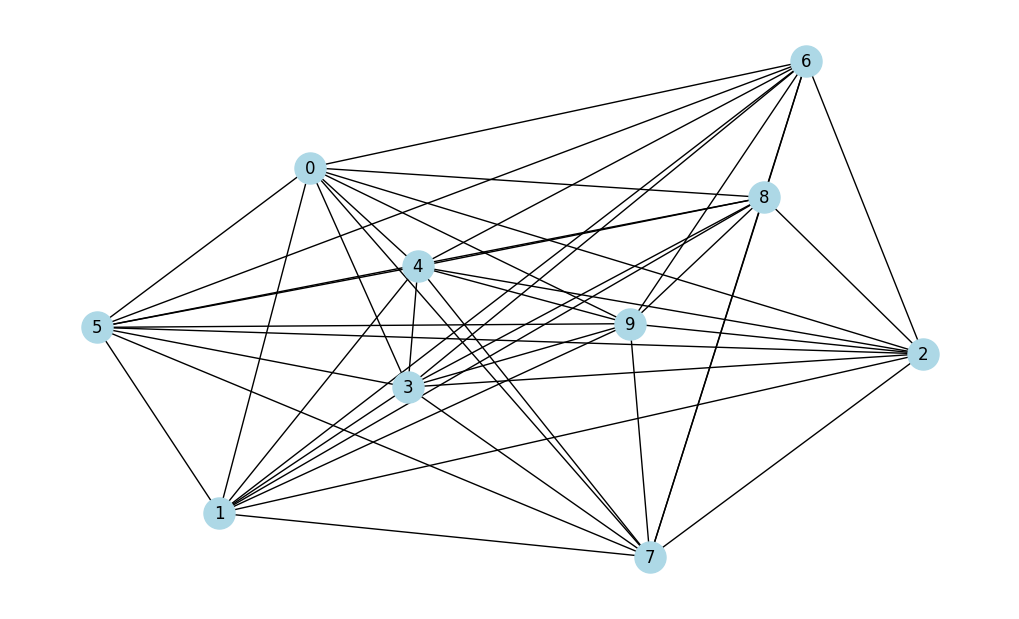

In [124]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

Implementation of Kruskal's greedy algorithm to find <b> the minimum spanning tree </b> <br>
for a weighted, connected, undirected graph.

In [125]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

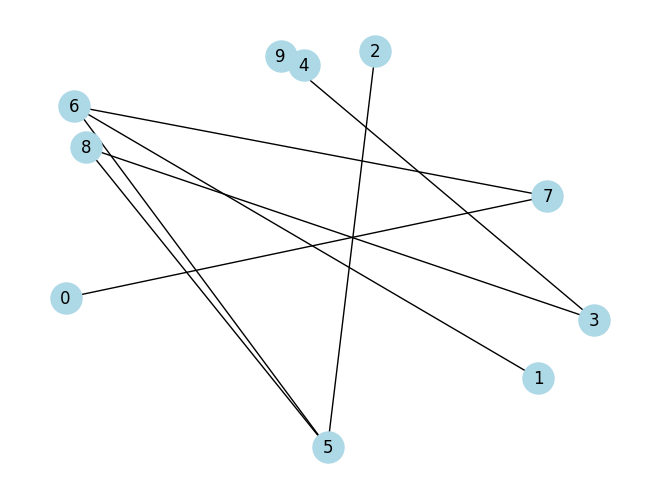

In [126]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [127]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (1, 6), (2, 5), (3, 8), (3, 9), (4, 9), (5, 8), (5, 6), (6, 7)]),
 9)

In [128]:
def kruskal_algorithm(graph) -> list:
    """
    The realization of Kruskal's algorithm
    used for finding the minimum spanning tree
    of a graph.

    :param graph: Randomly generated graph
    :return: list, List of edges needed to create MST
    """
    edges = list(graph.edges(data = True))
    sorted_edges = sorted(edges, key = lambda x: x[2]['weight'])
    mstk_v = {}
    mstk = {}


    def unite_groups(key_1: int, key_2: int):
        """
        Function unites groups into one.

        :param key_1, key_2: int, the key of a group to unite
        """
        mstk_v[key_1] = mstk_v[key_1].union(mstk_v[key_2])
        mstk_v.pop(key_2)
        mstk[key_1] = mstk[key_1] + mstk[key_2]
        mstk[key_1].append((edge[0], edge[1]))
        mstk.pop(key_2)

    i = 0
    for edge in sorted_edges:
        key_0 = 0
        key_1 = 0
        for s in mstk_v.items():
            if edge[0] in s[1]:
                key_0 = s[0]
                break 
        for s in mstk_v.items():
            if edge[1] in s[1]:
                key_1 = s[0]
                break 
        if not key_0 and not key_1 :
            i += 1
            mstk_v.setdefault(i, set())
            mstk_v[i].add(edge[0])
            mstk_v[i].add(edge[1])
            mstk.setdefault(i, [])
            mstk[i].append((edge[0], edge[1]))
        else:
            if key_0 == key_1:
                continue
            elif not key_0 or not key_1:
                group_key = key_0 if key_0 else key_1
                mstk_v[group_key].add(edge[0])
                mstk_v[group_key].add(edge[1])
                mstk[group_key].append((edge[0], edge[1]))
            else:
                if len(mstk_v[key_0]) >= len(mstk_v[key_1]):
                    unite_groups(key_0, key_1)
                else:
                    unite_groups(key_1, key_0)

    return sorted(mstk.values())


### Implementation details
At the beggining function receives randomly generated graph.

Then we extract edges, sort them by weight which is needed for algorithm's instance and initialize <br>
2 dictionaries <b>mstk_v</b> and <b>mstk</b> - dictionaries that contain information
about vertices and edges <br> in minimum spanning tree and update it as algorithm is being performed.

### Starting the algorithm

## Subtask 1.2

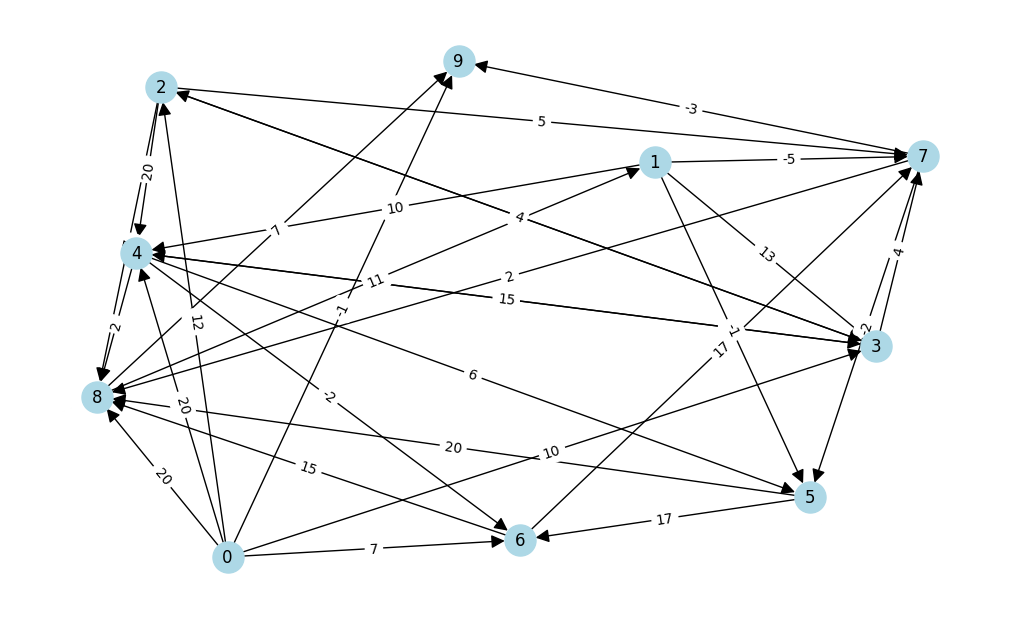

In [129]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

Implementation of Bellman-Ford algorithm that computes <b> the shortest path </b> <br>
from a single source vertext to all other vertices in a weighted digraph.

In [130]:
def bellman_ford_networkx(graph, source: int, show = True) -> dict:
    """
    The Bellman-Ford algorithm performed by
    NetworkX library.

    :param graph: Randomly generated graph
    :param start: int, Name of starting vertice (number in our case)
    :return: dict, Dictionary with keys as vertices and values as the 
    shortest distance to the each vertice.
    """
    try:
        _, dist = bellman_ford_predecessor_and_distance(graph, source)
        if show:
            for k, v in dist.items():
                print(f"Distance to {k}:", v)
    except:
        return "Negative cycle detected"
    return dist
print(bellman_ford_networkx(G, 0))

Distance to 0: 0
Distance to 9: -1
Distance to 2: 12
Distance to 3: 10
Distance to 4: 20
Distance to 6: 7
Distance to 8: 16
Distance to 7: 14
Distance to 5: 12
Distance to 1: 27
{0: 0, 9: -1, 2: 12, 3: 10, 4: 20, 6: 7, 8: 16, 7: 14, 5: 12, 1: 27}


### Implementation details
At the beggining function receives randomly generated graph, node to start algorithm performence from and the sign to show the distances in written form.

Then we extract edges, nodes, start node and initialize <b>distance_dict</b> - dictionary that contains information
about distances, with node as keys and distance as values.

### Starting the algorithm
- We initialize the distances to infinity, except for the start node - its distance is set to 0.
- Starting the main part - iterating for v-1 times, where v is a number of nodes of a graph.
We iterate through our directed graph and implement a checking if the sum of a distance to start
node in from node "u" in our 'table' of distances and the weight of a given edge is less than a distance to node v.
If so the distance from our node v is set to such sum (previously checked that if the node distance is set to infinity it is being reset to 0 for calculation)
- As a next step we perform another additional iteration as a checking if the graph contains any negative cycles. The checking is the exact copy of the previous iterations.
- As a result we print the results in written form and in dictionary as well.

In [131]:

def bellman_ford_algorithm(graph, start: int, show = True) -> dict:
    """
    The realization of Bellman-Ford algorithm
    that is used to find the shortest path in a directed
    weighted graph. 

    :param graph: Randomly generated graph
    :param start: int, Name of starting vertice (number in our case)
    :return: dict, Dictionary with keys as vertices and values as the 
    shortest distance to the each vertice.
    """
    edges = list(graph.edges(data = True))
    all_vertices = list(graph.nodes())
    sorted_graph = sorted(edges, key = lambda x: x)
    start_vertice = sorted_graph[start][0]
    distance_dict = {}

    for v in sorted(all_vertices):
        distance_dict[v] = float('inf')

    distance_dict[start_vertice] = 0
    for _ in range(len(all_vertices) - 1):
        for u, v, w in sorted_graph:
            if distance_dict[u] + w['weight'] < distance_dict[v]:
                distance_dict[u] = 0 if distance_dict[u] == float('inf') else distance_dict[u]
                distance_dict[v] = distance_dict[u] + w['weight']

    for u, v, w in sorted_graph:
        if distance_dict[u] + w['weight'] < distance_dict[v]:
            return "Negative cycle detected"

    
    if show:
        for v, distance in distance_dict.items():
            if distance != float('inf'):
                print(f'Distance to {v}: {distance}')
    return distance_dict

print(bellman_ford_algorithm(G, 0))

Distance to 0: 0
Distance to 1: 27
Distance to 2: 12
Distance to 3: 10
Distance to 4: 20
Distance to 5: 12
Distance to 6: 7
Distance to 7: 14
Distance to 8: 16
Distance to 9: -1
{0: 0, 1: 27, 2: 12, 3: 10, 4: 20, 5: 12, 6: 7, 7: 14, 8: 16, 9: -1}


---

## Time measuring for Kruskal's algorithm

In [132]:
import time
from tqdm import tqdm

In [133]:

def count_time(num_nodes: int, completeness: float, directed: bool, algorithm_name: str) -> float:
    """
    Counting runtime for each Kruskal's algorithm with given
    specifics of a graph, such as number of nodes, compeleteness and direction.

    :param num_nodes: list, List with number of nodes to check time for
    :param completeness: float, The completeness of a graph
    :param directed: bool, The direction of a graph
    :param algorithm_name: str, The "name" of an algorithm
    :return: float, Runtime of an algorithm
    """
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for _ in tqdm(range(NUM_OF_ITERATIONS)):

        G = gnp_random_connected_graph(num_nodes, completeness, directed)
        start = time.time()
     
        if algorithm_name == "kruskal":
            tree.minimum_spanning_tree(G, algorithm="kruskal")
        else:
            kruskal_algorithm(G)

        end = time.time()
        time_taken += end - start

    return time_taken / NUM_OF_ITERATIONS


In [134]:
def testing_kruskal(num_nodes: list,\
     completeness: float, directed: bool) -> dict:
     """
     Processing of data, received after count_time function for
     of each implementation of Kruskal's algorithm for certain
     given number of nodes and completeness.

     :param num_nodes: list, List with number of nodes to check time for
     :param completeness: float, The completeness of a graph
     :param directed: bool, The direction of a graph
     :return: dict, The results of testing, key is a name of an algorithm,
     value is dictionary, which keys are the number of nodes in a graph 
     and values are runtimes
     """
     results = {}
     algorithms = ['our_kruskal', 'kruskal']

     for num in num_nodes:
          for algorithm in algorithms:
               run_time_res = count_time(num, completeness, directed, algorithm)
               if algorithm not in results:
                    results.setdefault(algorithm, {})
               results[algorithm][num] = run_time_res
     return results

100%|██████████| 1000/1000 [00:00<00:00, 20184.04it/s]


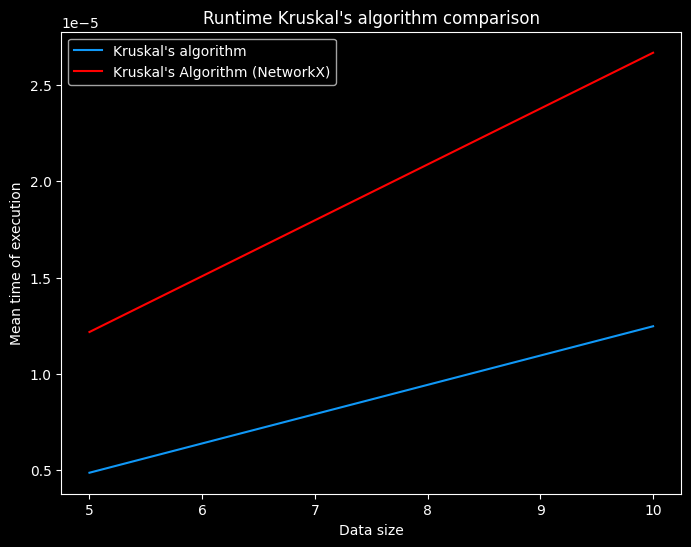

Visualization of runtime differences for 2 implementations of Kruskal's algorithm


In [135]:

def visualization_comparison_kruskal(results: dict) -> str:
    """
    The visualization of runtime differences
    of Kruskal's algorithms implemented by us 
    and NetworkX library using Matplotlib library.

    :param results: dict, The result of testing_kruskal function
    """
    nodes = np.array(list(results['our_kruskal'].keys()))
    our_kruskal_result = list(results['our_kruskal'].values())
    kruskal_result = list(results['kruskal'].values())

    plt.style.use('dark_background')
    plt.figure(figsize = (8, 6))
    plt.plot(nodes, our_kruskal_result, color = '#1098F7', label = "Kruskal's algorithm", linewidth = 1.5)
    plt.plot(nodes, kruskal_result, color = 'red', label = "Kruskal's Algorithm (NetworkX)", linewidth = 1.5)


    plt.title("Runtime Kruskal's algorithm comparison")
    plt.xlabel('Data size')
    plt.ylabel('Mean time of execution')
    plt.legend()
    plt.show()

    return "Visualization of runtime differences for 2 implementations of Kruskal's algorithm"

print(visualization_comparison_kruskal(testing_kruskal([5, 10], 0.4, False)))


- <b>500 iterations</b> <br>
For an example of 5, 10, 15, 20, 25, 50, 100, 200, 500 nodes, with completness 0.4 our algorithm works faster <br> 
on bigger examples and works almost the same on small ones (faster a little bit than implementation of NetworkX library).

Testing on the same example with completness 1 our algorithm continues to perform faster.

- <b>1000 iterations</b> <br>
The same tendency is kept on bigger amount and smaller amount of iterations, but same give characteristics. Our algorithm performs faster.

## Time measuring for Bellman-Ford algorithm

In [136]:

def count_time_bf(num_nodes: int, completeness: float, directed: bool, algorithm_name: str, start_node: int) -> float:
    """
    Counting runtime for each Bellman-Ford algorithm with given
    specifics of a graph, such as number of nodes, compeleteness and direction.

    :param num_nodes: list, List with number of nodes to check time for
    :param completeness: float, The completeness of a graph
    :param directed: bool, The direction of a graph
    :param algorithm_name: str, The "name" of an algorithm
    :param start_node: int, The node to start performing algorithm on
    :return: float, Runtime of an algorithm
    """
    NUM_OF_ITERATIONS = 100
    time_taken = 0
    for _ in tqdm(range(NUM_OF_ITERATIONS)):

        G = gnp_random_connected_graph(num_nodes, completeness, directed)
        start = time.time()
     
        if algorithm_name == "bellman-ford_x":
            bellman_ford_networkx(G, start_node, False)
        else:
            bellman_ford_algorithm(G, start_node, False)

        end = time.time()
        time_taken += end - start

    return time_taken / NUM_OF_ITERATIONS


In [137]:
def testing_bellman_ford(num_nodes: list,\
     completeness: float, directed: bool, start_node: int) -> dict:
     """
     Processing of data, received after count_time function for
     of each implementation of Bellman-Ford algorithm for certain
     given number of nodes and completeness.

     :param num_nodes: list, List with number of nodes to check time for
     :param completeness: float, The completeness of a graph
     :param directed: bool, The direction of a graph
     :param start_node: int, The node to start performing algorithm on
     :return: dict, The results of testing, key is a name of an algorithm,
     value is dictionary, which keys are the number of nodes in a graph 
     and values are runtimes
     """
     results = {}
     algorithms = ['bellman-ford', 'bellman-ford_x']

     for num in num_nodes:
          for algorithm in algorithms:
               run_time_res = count_time_bf(num, completeness, directed, algorithm, start_node)
               if algorithm not in results:
                    results.setdefault(algorithm, {})
               results[algorithm][num] = run_time_res
     return results

100%|██████████| 100/100 [00:00<00:00, 5122.44it/s]


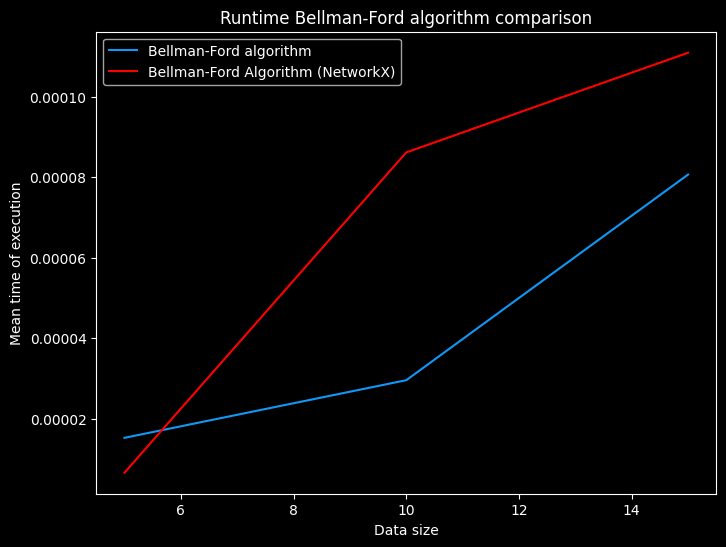

Visualization of runtime differences for 2 implementations of Bellman-Ford algorithm


In [138]:

def visualization_comparison_bellman_ford(results: dict) -> str:
    """
    The visualization of runtime differences
    of Bellman-ford algorithms implemented by us 
    and NetworkX library using Matplotlib library.

    :param results: dict, The result of testing_kruskal function
    """
    nodes = np.array(list(results['bellman-ford'].keys()))
    our_kruskal_result = list(results['bellman-ford'].values())
    kruskal_result = list(results['bellman-ford_x'].values())

    plt.style.use('dark_background')
    plt.figure(figsize = (8, 6))
    plt.plot(nodes, our_kruskal_result, color = '#1098F7', label = 'Bellman-Ford algorithm', linewidth = 1.5)
    plt.plot(nodes, kruskal_result, color = 'red', label = 'Bellman-Ford Algorithm (NetworkX)', linewidth = 1.5)


    plt.title('Runtime Bellman-Ford algorithm comparison')
    plt.xlabel('Data size')
    plt.ylabel('Mean time of execution')
    plt.legend()
    plt.show()

    return 'Visualization of runtime differences for 2 implementations of Bellman-Ford algorithm'

print(visualization_comparison_bellman_ford(testing_bellman_ford([5, 10, 15], 1, True, 0)))

This algorithm is harder to perform than Kruskal's algorithm that is why we test on 500 <= iterations <br>
For an example of 10, 15, 20, 25, 50, 100, 250 nodes, with completness 0.4 our algorithm works <br> 
a little bit slower on some points than implementation of NetworkX library. (tested for 200, 250, 500 iterations)

For completness of 1 our algorithm works faster of 200 iterations than NetworkX's algorithm.

## Task 2. Decision Tree Classifier 

In [139]:
# scikit-learn package
# from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 

#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [140]:
# Load dataset
# iris = load_iris()
# dir(iris)

In [141]:
# iris.data.shape

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [142]:
# iris.data[0:2]

### To undestand data little bit better, let's plot some features

In [143]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# X = cancer.data[:, 0]


Text(0, 0.5, 'concave points ')

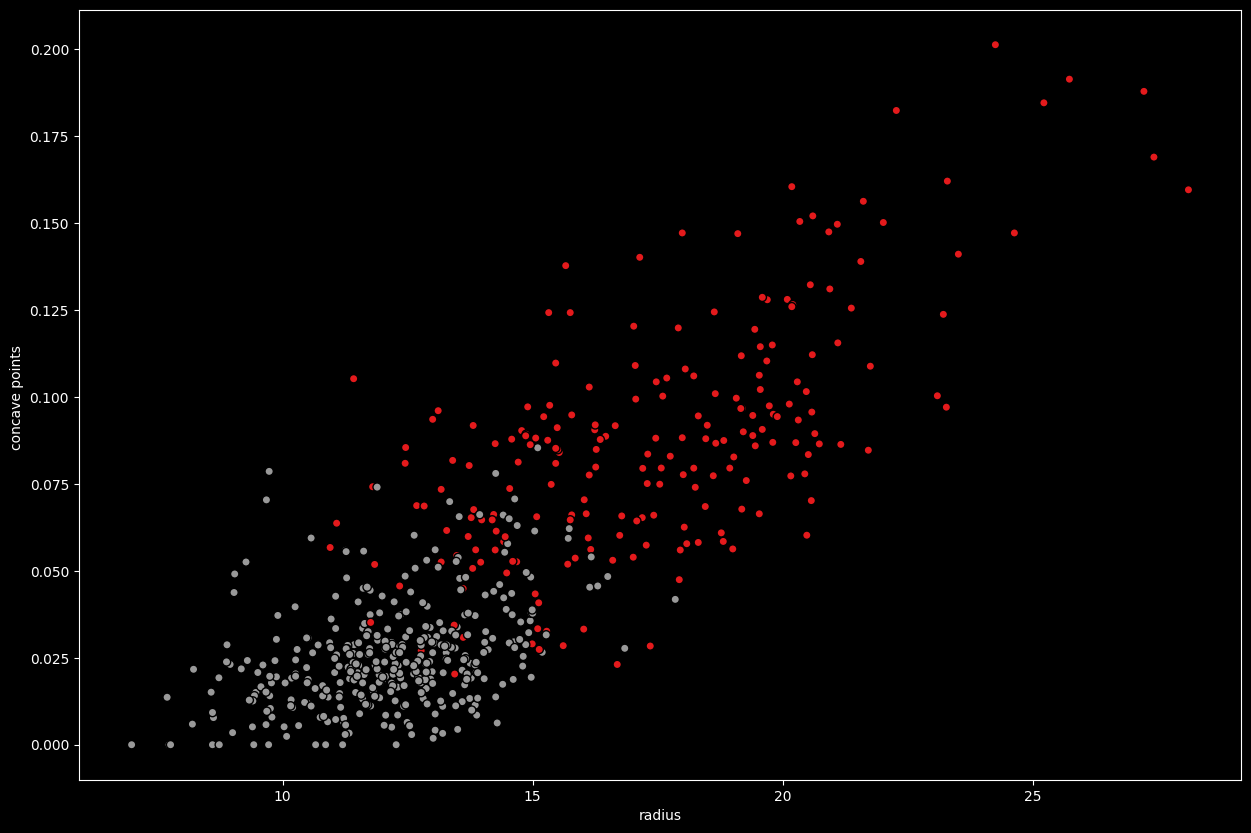

In [144]:
# X = iris.data[:, :2]  # we only take the first two features.
# y = iris.target

X = cancer.data
y = cancer.target

plt.figure(2, figsize=(15, 10))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0]  , X[:, 7], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("radius")
plt.ylabel("concave points ")


From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [145]:
# clf = DecisionTreeClassifier()

X, y = cancer.data, cancer.target
X = np.array(list(zip(X[:, 0]  , X[:, 7]))) #transformed into list with only two features: radius and concave points
X.shape, y.shape


((569, 2), (569,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [146]:
# X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
# X_test.shape, y_test.shape

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [147]:
# clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [148]:
# import graphviz 
# dot_data = tree.export_graphviz(clf, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("cancer")


In [149]:
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                     feature_names=cancer.feature_names,  
#                     class_names=cancer.target_names,  
#                     filled=True, rounded=True,  
#                     special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [150]:
# predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [151]:
# sum(predictions == y_test) / len(y_test)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [152]:
# y_test


Here you can traverse the tree above by yourself and make sure that prediction works

In [153]:
# X_test[1]

In [154]:
# clf.predict([X_test[1]])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [155]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [156]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None 
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size
        X = [X[:, 0], X[:, 1]] # just spliting each feature into different lists as i did before
        tree = self.grow_tree(X, y)
        return tree

    def grow_tree(self, X, y, depth = 0): 
        #треба тут регулар кейс де макс депс річд, але хз шо воно має повертати.
        accuracy = []  
        labels = np.unique(y).tolist()           
        for feat in X:
            _, _, x_right_brunch, _ = self.split(feat)
            accuracy.append(self.define_gini(x_right_brunch, labels))
        best_feat = X[accuracy.index(min(accuracy))]
        x_left, y_left, x_right, y_right = self.split(best_feat)
        depth += 1
        left_brunch = self.grow_tree(x_left, y_left, depth)
        right_brunch = self.grow_tree(x_right, y_right, depth)

    
    @staticmethod
    def split(feat):
        arr = sorted(zip(feat, y), key= lambda x: x[0])
        for el in arr:
            if el[1] == 0:
                pivot = el[0]
                break
        left, right = [], []
        for el in arr: #
            left.append(el) if el[0] < pivot else right.append(el)
        x_left, y_left = [el[0] for el in left], [el[1] for el in left]
        x_right, y_right = [el[0] for el in right], [el[1] for el in right]
        return x_left, y_left, x_right, y_right

    @staticmethod
    def define_gini(arr, labels):
        gini = 1
        arr = [el[1] for el in arr]
        for y in labels:
            n = arr.count(y)
            gini -= n / len(arr)
        return gini

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass


# DecisionTreeClassifier.grow_tree()


In [157]:
# X = [X[:, 0], X[:, 1]]
# DecisionTreeClassifier.grow_tree(DecisionTreeClassifier, X=X, y=y)
# DecisionTreeClassifier.__dict__
clf = DecisionTreeClassifier(10)
clf = clf.fit(X, y)
# for feat in X:
#     arr = zip(feat, y)


IndexError: invalid index to scalar variable.

In [45]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)